This notebook generates a Hovmoller plot of temperature vs. depth for the abrupt experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import IPython.display

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client()
display(client)

Client Scheduler: tcp://127.0.0.1:46681 Dashboard: /proxy/43205/status,Cluster Workers: 3 Cores: 6 Memory: 25.77 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt.db'

session = cc.database.create_session(db)

directory_list = ['/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_cont',
                     '/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_rcp45cool',
                     '/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_rcp45warm']

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,42207
1,1deg_jra55_ryf_rcp45cool,47726
2,1deg_jra55_ryf_rcp45warm,47640


In [5]:
# Control

control_expt = '1deg_jra55_ryf_cont'
control = cc.querying.get_variables(session, experiment = control_expt)

temp_control = cc.querying.getvar(control_expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')
 # [:-1] to remove 2200-01-01:
GAT_control = cc.querying.getvar(control_expt, 'temp_global_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')
SST_control = cc.querying.getvar(control_expt, 'temp_surface_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')

In [6]:
# Cool

cool_expt = '1deg_jra55_ryf_rcp45cool'
cool = cc.querying.get_variables(session, experiment = cool_expt)

temp_cool = cc.querying.getvar(cool_expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')
GAT_cool = cc.querying.getvar(cool_expt, 'temp_global_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')
SST_cool = cc.querying.getvar(cool_expt, 'temp_surface_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')

GAT_cool_anom = GAT_cool - GAT_control
SST_cool_anom = SST_cool - SST_control

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [7]:
# Warm

warm_expt = '1deg_jra55_ryf_rcp45warm'
warm = cc.querying.get_variables(session, experiment = warm_expt)

temp_warm = cc.querying.getvar(warm_expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')
GAT_warm = cc.querying.getvar(warm_expt, 'temp_global_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')
SST_warm = cc.querying.getvar(warm_expt, 'temp_surface_ave', session)[:-1].chunk(chunks=3650).load().groupby('time.year').mean('time')

GAT_warm_anom = GAT_warm - GAT_control
SST_warm_anom = SST_warm - SST_control

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Next, we load cell area (denoted $a(x,y,z)$) from the ocean_grid file, construct a mask from the temperature file and make a profile of the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$
*Note that this mask ignores the presence of partial cells, for now*.

In [8]:
cc.querying.get_variables(session, control_expt)[cc.querying.get_variables(session, control_expt)['name'].str.lower().str.match('area')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
343,area_t,tracer cell area,static,output059/ocean/ocean-2d-area_t.nc,19,1900-01-01 00:00:00,1900-01-01 00:00:00
344,area_u,velocity cell area,static,output040/ocean/ocean-2d-area_u.nc,19,1900-01-01 00:00:00,1900-01-01 00:00:00


In [9]:
area_t = cc.querying.getvar(control_expt, 'area_t', session, n=1)#.mean('time')
mask = temp_control.isel(time=0).copy()
mask = mask / mask                 ## This seems pretty dodgy to me, but it works!
area = mask * area_t
area_sum = area.sum('xt_ocean').sum('yt_ocean')
IPython.display.clear_output()

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \theta(x,y,z,t)}{A(z)}$$
where $T$ is the average temperature and $\theta$ the potential temperature.

In [10]:
var = area_t * (temp_cool - temp_control)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_hov_cool = temp_hov / area_sum

var = area_t * (temp_warm - temp_control)
temp_hov = var.sum('xt_ocean').sum('yt_ocean').chunk(chunks='auto').compute()
temp_hov_warm = temp_hov / area_sum

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


We can use xarray for a quick and dirty plot of this data:

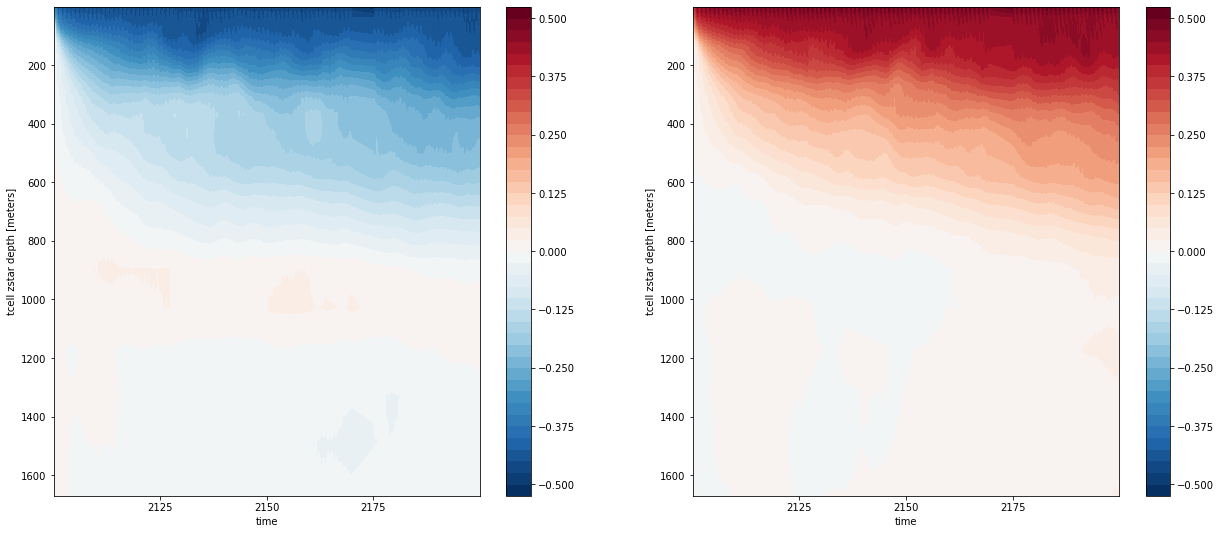

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (21,9))
p1 = temp_hov_cool[:,:33].T.plot.contourf(ax=ax[0], levels=45,yincrease=False)
p2 = temp_hov_warm[:,:33].T.plot.contourf(ax=ax[1], levels=45,yincrease=False, add_colorbar=False)
cb = plt.colorbar(p1,ax=ax[1],orientation='vertical')